In [31]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import json

# Define paths
base_dir = Path().resolve()
data_dir = base_dir / 'data'
data_path = data_dir / 'dataset.csv'

# Load dataset
df = pd.read_csv(data_path)

# Drop missing values and duplicates
print(f"Rows before dropping NA: {len(df)}")
df = df.dropna()
print(f"Rows after dropping NA: {len(df)}")

print(f"Rows before dropping duplicates: {len(df)}")
df = df.drop_duplicates(subset='track_id')
print(f"Rows after dropping duplicates: {len(df)}")

# Convert duration from ms to seconds and drop old column
df['duration_sec'] = df['duration_ms'] / 1000
df = df.drop(columns='duration_ms')

# Normalize audio features
features_to_normalize = ['danceability', 'energy', 'loudness', 'speechiness', 
                         'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
scaler = MinMaxScaler()
df[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Extract the first artist and count the number of artists
df['artist'] = df['artists'].apply(lambda x: x.split(';')[0] if ';' in x else x)
df['num_artists'] = df['artists'].apply(lambda x: len(x.split(';')))

# Convert genre to category and encode as numeric labels
df['genre_label'] = df['track_genre'].astype('category').cat.codes

# Save genre mapping
genre_mapping = dict(enumerate(df['track_genre'].astype('category').cat.categories))
with open('genre_mapping.json', 'w') as f:
    json.dump(genre_mapping, f)

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Save processed data
df.to_csv('generel_data.csv', index=False)


Rows before dropping NA: 114000
Rows after dropping NA: 113999
Rows before dropping duplicates: 113999
Rows after dropping duplicates: 89740


## Ensure balanced training data for supervised models, preventing bias toward overrepresented genres.

After oversampling or undersampling, the genres are now equally represented. This ensures that supervised models like Random Forest or SVM won't be biased toward the majority class, leading to better generalization across genres.

OBS. use balanced data exclusively for supervised learning tasks like genre prediction. 

/var/folders/0q/x2dyyz5d7xs7zzrfhj8l86840000gp/T/ipykernel_97076/2877290281.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")


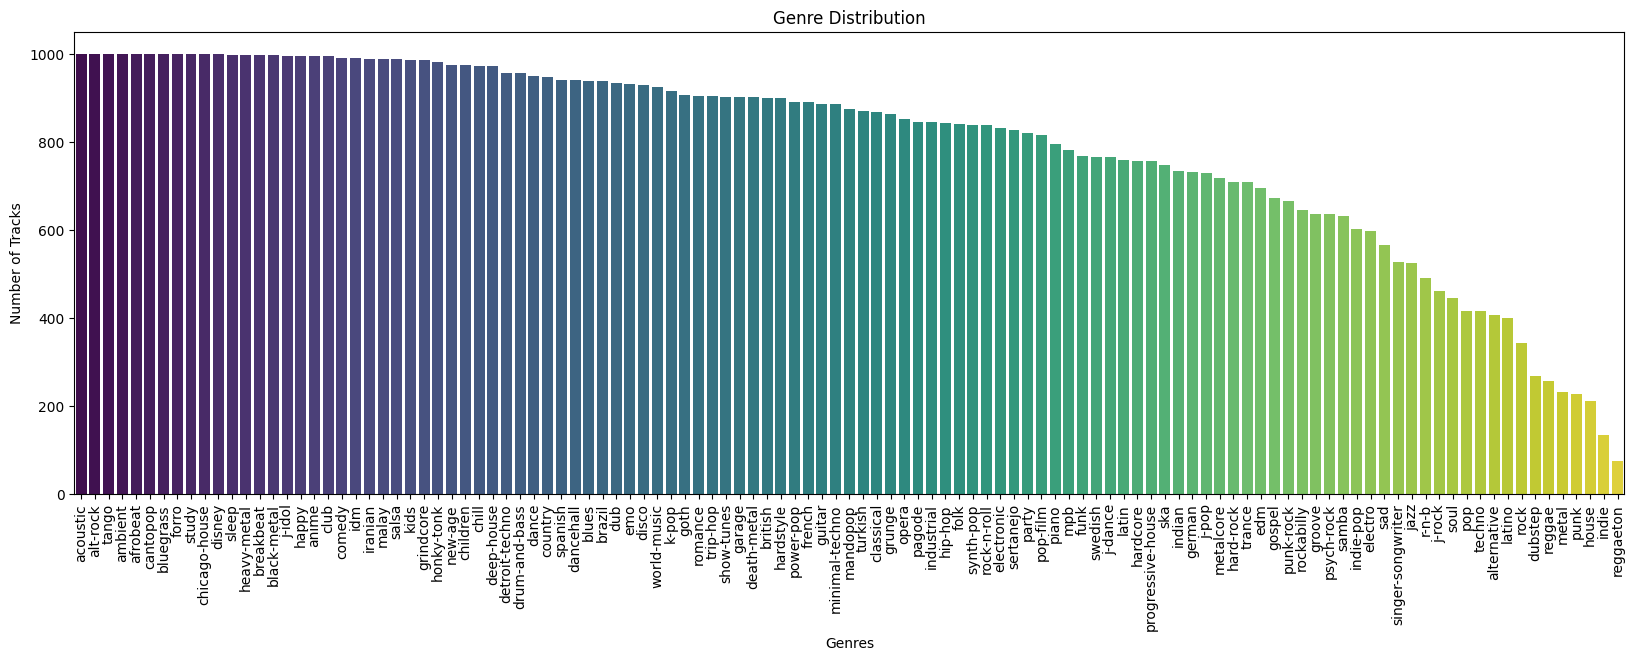

In [28]:
import matplotlib.pyplot as plt

# Count distribution of track genres
genre_counts = df['track_genre'].value_counts()

# Plot class distribution
plt.figure(figsize=(20, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
plt.title("Genre Distribution")
plt.xticks(rotation=90)
plt.ylabel("Number of Tracks")
plt.xlabel("Genres")
plt.show()

# Oversampling/Undersampling using imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Define features and labels
X = df.drop(columns=['track_genre', 'genre_label'])
y = df['genre_label']

# Oversample to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_balanced, y_balanced = oversampler.fit_resample(X, y)

# Optional: Undersample
# undersampler = RandomUnderSampler(random_state=42)
# X_balanced, y_balanced = undersampler.fit_resample(X, y)

# Update DataFrame with balanced data
df_balanced = pd.concat([pd.DataFrame(X_balanced), pd.Series(y_balanced, name='genre_label')], axis=1)

if 'Unnamed: 0' in df_balanced.columns:
    df_balanced = df_balanced.drop(columns=['Unnamed: 0'])

df_balanced.to_csv('balanced_data.csv', index=False)


The chart visualizes the distribution of track genres in the dataset. Each bar represents a genre, with its height indicating the number of tracks belonging to that genre. The chart reveals significant class imbalance, as some genres (e.g., "acoustic" and "afrobeat") have far more tracks compared to others (e.g., "reggaeton" and "house"). This uneven distribution highlights the need for balancing techniques to ensure fair representation of all genres during analysis.

## clustering_df
Use for unsupervised learning (clustering). It contains the original unbalanced dataset with features ready for clustering.

In [32]:
# Retain track_id for identification purposes
track_id = df['track_id']

# Drop categorical and irrelevant columns (but keep track_id separately)
clustering_df = df.drop(columns=['artist', 'track_genre', 'genre_label', 'track_id'])

# Ensure all remaining columns are numeric
numeric_columns = clustering_df.select_dtypes(include=['float64', 'int64']).columns
clustering_df = clustering_df[numeric_columns]

# Scale numeric features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
clustering_features = scaler.fit_transform(clustering_df)

# Optional: Convert back to DataFrame for interpretability
clustering_df_scaled = pd.DataFrame(clustering_features, columns=clustering_df.columns)

# Add track_id back to the scaled DataFrame
clustering_df_scaled['track_id'] = track_id.values

# Remove unnecessary columns if present
if 'Unnamed: 0' in clustering_df_scaled.columns:
    clustering_df_scaled = clustering_df_scaled.drop(columns=['Unnamed: 0'])

# Save clustering-ready data with track_id
clustering_df_scaled.to_csv('clustering_data.csv', index=False)


## Use of the datasets:

### EDA

- Use generel_data for general insights and distribution visualizations.
- Use balanced_data to analyze how balancing affects distributions, if needed.

### Clustering

- Load clustering_data
- Scale it before clustering

In [25]:
scaler = StandardScaler()
clustering_features = scaler.fit_transform(clustering_df)

### Supervised Learning

Load balanced_data to train and evaluate models.